In [24]:
import torch
import segmentation_models_pytorch as smp
import numpy as np
import cv2
import os
import random
from torch import nn
import matplotlib.pyplot as plt


In [25]:
# 這裡是讀取所有圖片
def read_images_from_folders(root_folder, subfolders):
    images_dict = {}
    for folder_name in subfolders:
        folder_path = os.path.join(root_folder, folder_name)
        print(f"正在讀取資料夾: {folder_path}") # 增加提示，方便除錯
        images = []
        if not os.path.isdir(folder_path): # 檢查資料夾是否存在
            print(f"警告: 資料夾不存在 {folder_path}")
            images_dict[folder_name] = images # 即使資料夾不存在，也給它一個空列表
            continue

        for filename in os.listdir(folder_path):
            if filename.lower().endswith((".jpg", ".png")):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                else:
                    print(f"無法讀取圖片: {img_path}")
        images_dict[folder_name] = images
        if not images:
            print(f"注意: 資料夾 {folder_name} 中沒有找到符合條件的圖片。")
    return images_dict


root_folder = r".\ETT_v3\Fold3"


subfolders = ["test", "testannot", "train", "trainannot", "val", "valannot"]
images_data = read_images_from_folders(root_folder, subfolders)

print("\n--- 讀取結果 ---")
for folder_name, images in images_data.items():
    print(f"{folder_name} 讀取 {len(images)} 張圖片")

train_images = images_data.get("train", [])
val_images = images_data.get("val", [])
test_images = images_data.get("test", [])
trainannot_images = images_data.get("trainannot", [])
valannot_images = images_data.get("valannot", [])
testannot_images = images_data.get("testannot", []) 


if train_images:
    print(f"\n成功讀取到 train 資料夾的第一張圖片，形狀: {train_images[0].shape}")
else:
    print("\n未讀取到 train 資料夾的圖片。")

if testannot_images: 
    print(f"成功讀取到 testannot 資料夾的第一張圖片，形狀: {testannot_images[0].shape}")
else:
    print("\n未讀取到 testannot 資料夾的圖片。")

正在讀取資料夾: .\ETT_v3\Fold3\test
正在讀取資料夾: .\ETT_v3\Fold3\testannot
正在讀取資料夾: .\ETT_v3\Fold3\train
正在讀取資料夾: .\ETT_v3\Fold3\trainannot
正在讀取資料夾: .\ETT_v3\Fold3\val
正在讀取資料夾: .\ETT_v3\Fold3\valannot

--- 讀取結果 ---
test 讀取 47 張圖片
testannot 讀取 47 張圖片
train 讀取 287 張圖片
trainannot 讀取 287 張圖片
val 讀取 47 張圖片
valannot 讀取 47 張圖片

成功讀取到 train 資料夾的第一張圖片，形狀: (3028, 2366)
成功讀取到 testannot 資料夾的第一張圖片，形狀: (3028, 2359)


In [26]:
#把圖片全都統一成256*256
processed_images_data = {}

def preprocess_images(images_data, target_size=(256, 256)):


    for folder_name, images in images_data.items():
        processed_images = []
        for image in images:
            resized_image = cv2.resize(image, target_size)

            processed_images.append(resized_image)

        processed_images_data[folder_name] = processed_images

    return processed_images_data

In [27]:
import cv2
import numpy as np
import random

def adjust_contrast_and_brightness(image, alpha_range=(0.8, 1.2), beta_range=(-20, 20)):
    alpha = random.uniform(*alpha_range)  # 對比度
    beta = random.randint(*beta_range)    # 亮度
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

def random_affine_rotate(image, mask, angle_range=(-10, 10)):
    angle = random.uniform(*angle_range)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
    image_rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    mask_rotated = cv2.warpAffine(mask, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)
    return image_rotated, mask_rotated

def random_scale_and_crop_pair(image, mask, target_size=(256, 256), scale_range=(1.0, 1.5)):
    scale = random.uniform(*scale_range)
    new_h = int(image.shape[0] * scale)
    new_w = int(image.shape[1] * scale)

    image_scaled = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    mask_scaled = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    if new_h < target_size[1] or new_w < target_size[0]:
        padded_h = max(new_h, target_size[1])
        padded_w = max(new_w, target_size[0])
        img_pad = np.zeros((padded_h, padded_w), dtype=image.dtype)
        mask_pad = np.zeros((padded_h, padded_w), dtype=mask.dtype)
        img_pad[:new_h, :new_w] = image_scaled
        mask_pad[:new_h, :new_w] = mask_scaled
        image_scaled, mask_scaled = img_pad, mask_pad

    top = random.randint(0, image_scaled.shape[0] - target_size[1])
    left = random.randint(0, image_scaled.shape[1] - target_size[0])
    image_cropped = image_scaled[top:top + target_size[1], left:left + target_size[0]]
    mask_cropped = mask_scaled[top:top + target_size[1], left:left + target_size[0]]

    return image_cropped, mask_cropped

def random_flip_pair(image, mask):
    # 僅水平翻轉
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)
    return image, mask

def augment_train_images(train_images, trainannot_images, augment_times=2, target_size=(256, 256)):
    augmented_images = []
    augmented_annots = []

    for img, ann in zip(train_images, trainannot_images):
        base_img = cv2.resize(img, target_size)
        base_ann = cv2.resize(ann, target_size, interpolation=cv2.INTER_NEAREST)
        augmented_images.append(base_img)
        augmented_annots.append(base_ann)

        for _ in range(augment_times):
            aug_img, aug_ann = random_scale_and_crop_pair(img, ann, target_size)
            aug_img, aug_ann = random_affine_rotate(aug_img, aug_ann)
            aug_img, aug_ann = random_flip_pair(aug_img, aug_ann)
            aug_img = adjust_contrast_and_brightness(aug_img)
            augmented_images.append(aug_img)
            augmented_annots.append(aug_ann)

    return augmented_images, augmented_annots

# 使用增強
aug_train_images, aug_trainannot_images = augment_train_images(train_images, trainannot_images, augment_times=2)

# 更新 dict
augmented_images_data = images_data.copy()
augmented_images_data["train"] = aug_train_images
augmented_images_data["trainannot"] = aug_trainannot_images

# 驗證
print(f"train 增強後圖片數量: {len(augmented_images_data['train'])}")
print(f"trainannot 增強後圖片數量: {len(augmented_images_data['trainannot'])}")


train 增強後圖片數量: 861
trainannot 增強後圖片數量: 861


In [28]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

processed_images_data = preprocess_images(images_data)

# 自訂 Dataset 類別
class SegmentationDataset(Dataset):
    def __init__(self, images, masks):
        assert len(images) == len(masks), "影像與標註數量不一致"
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # 灰階轉 float32 並標準化
        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # 增加 channel 維度
        image = np.expand_dims(image, axis=0)
        mask = np.expand_dims(mask, axis=0)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

# 建立 Dataset 與 DataLoader（使用增強後的 train 和前處理後的 val）
train_dataset = SegmentationDataset(
    images=augmented_images_data["train"],
    masks=augmented_images_data["trainannot"]
)

val_dataset = SegmentationDataset(
    images=processed_images_data["val"], # <-- 修改這裡！
    masks=processed_images_data["valannot"] # <-- 修改這裡！
)
test_dataset = SegmentationDataset(
    images=processed_images_data["test"],
    masks=processed_images_data["testannot"]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [29]:
print(f"訓練資料集大小：{len(train_dataset)}")
print(f"驗證資料集大小：{len(val_dataset)}")
print(f"測試資料集大小：{len(test_dataset)}")

# 檢查資料是否正確載入
for i in range(3):
    img, mask = test_dataset[i]
    print(f"測試資料集第 {i+1} 張影像形狀：{img.shape}, 標註形狀：{mask.shape}")

訓練資料集大小：861
驗證資料集大小：47
測試資料集大小：47
測試資料集第 1 張影像形狀：torch.Size([1, 256, 256]), 標註形狀：torch.Size([1, 256, 256])
測試資料集第 2 張影像形狀：torch.Size([1, 256, 256]), 標註形狀：torch.Size([1, 256, 256])
測試資料集第 3 張影像形狀：torch.Size([1, 256, 256]), 標註形狀：torch.Size([1, 256, 256])


In [30]:
print(f"測試資料集大小：{len(test_loader.dataset)}")
for batch in test_loader:
    print(f"批次大小：{len(batch[0])}")

測試資料集大小：47
批次大小：32
批次大小：15


In [31]:
import os
import torch
import numpy as np
import cv2
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, Callback
import torchmetrics
from pprint import pprint

# 設定隨機種子
seed_everything(42)


# 定義模型類別
class PetModel(pl.LightningModule):
    def __init__(self, arch="MAnet", encoder_name="resnet34", in_channels=1, out_classes=1, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()

        # 初始化模型架構
        self.model = smp.create_model(
            arch, 
            encoder_name=encoder_name, 
            in_channels=in_channels, 
            classes=out_classes, 
            activation="sigmoid",
        )

        # 損失函數
        self.dice_loss = smp.losses.DiceLoss(mode='binary')
        self.bce_loss = nn.BCELoss()

        # 指標
        self.train_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1)
        self.val_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1)

        # 每公分像素數：每 72 pixel = 1 cm
        self.pixel_per_cm = 72.0

    def forward(self, x):
        return self.model(x)

    def shared_step(self, batch, stage):
        images, masks = batch
        outputs = self.forward(images)

        # 計算損失
        loss = 0.5 * self.dice_loss(outputs, masks) + 0.5 * self.bce_loss(outputs, masks)
        preds = (outputs > 0.5).float()

        # 計算 IoU
        iou_metric = self.train_iou if stage == "train" else self.val_iou
        iou_metric(preds, masks.int())

        # 紀錄損失與指標
        self.log(f'{stage}_loss', loss, prog_bar=True)
        self.log(f'{stage}_iou', iou_metric, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "val")

    def extract_tip_y(self, mask):
        # mask: tensor (B, 1, H, W) or (B, H, W)
        if mask.ndim == 4:
            mask = mask.squeeze(1)
        y_coords = []
        for m in mask:
            indices = torch.nonzero(m > 0.5, as_tuple=False)
            if len(indices) == 0:
                y_coords.append(torch.tensor(0.0, device=mask.device))  # 預測不到，設為 0
            else:
                y_coords.append(indices[:, 0].max().float())  # y 座標最大值（最下方）
        return torch.stack(y_coords)

    def compute_avg_acc_cm(self, preds_y, targets_y):
        abs_diff = torch.abs(preds_y - targets_y)
        return (abs_diff / self.pixel_per_cm).mean()

    def compute_acc_within_threshold(self, preds_y, targets_y, threshold_cm):
        abs_diff = torch.abs(preds_y - targets_y)
        within_threshold = (abs_diff / self.pixel_per_cm) <= threshold_cm
        return within_threshold.float().mean() * 100  # 百分比

    def test_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.forward(images)
        outputs = (outputs > 0.5).float()

        # IoU
        test_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1).to(self.device)
        iou_score = test_iou(outputs, masks.int())

        # 提取端點 Y 座標
        pred_y = self.extract_tip_y(outputs)
        gt_y = self.extract_tip_y(masks)

        # 公分誤差計算
        avg_acc_cm = self.compute_avg_acc_cm(pred_y, gt_y)
        acc_0_5_cm = self.compute_acc_within_threshold(pred_y, gt_y, 0.5)
        acc_1_0_cm = self.compute_acc_within_threshold(pred_y, gt_y, 1.0)

        # Logging
        self.log('test_iou', iou_score, prog_bar=True)
        self.log('test_avg_acc_cm', avg_acc_cm, prog_bar=True)
        self.log('test_acc_0.5_cm', acc_0_5_cm, prog_bar=True)
        self.log('test_acc_1.0_cm', acc_1_0_cm, prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            }
        }


# IoU Callback
class IouCallBack(Callback):
    def __init__(self):
        super().__init__()
        self.train_ious = []
        self.valid_ious = []

    def on_validation_epoch_end(self, trainer, pl_module):
        self.train_ious.append(trainer.callback_metrics.get("train_iou"))
        self.valid_ious.append(trainer.callback_metrics.get("val_iou"))

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_iou',
    mode='max',
    save_top_k=1,
    dirpath='./checkpoints',
    filename='best-checkpoint'
)
early_stopping = EarlyStopping(
    monitor='val_iou',
    patience=30,
    mode='max'
)
iou_callback = IouCallBack()

# Model
model = PetModel(
    arch="MAnet",  # 模型架構
    encoder_name="resnet34",  # 編碼器
    in_channels=1,  # 輸入通道數
    out_classes=1,  # 輸出通道數
    learning_rate=1e-4  # 學習率
)

# Trainer
trainer = Trainer(
    callbacks=[checkpoint_callback, early_stopping, iou_callback],
    max_epochs=200,
    accelerator="gpu",
    devices=1,
    log_every_n_steps=10,
)

# 執行訓練
trainer.fit(model, train_loader, val_loader)
print("Training complete. Best model saved.")


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | MAnet              | 31.8 M | train
1 | dice_loss | DiceLoss           | 0      | train
2 | bce_loss  | BCELoss            | 0      | train
3 | train_iou | BinaryJaccardIndex | 0      | train
4 | val_iou   | BinaryJaccardIndex | 0      | train
---------------------------------------------------------
31.8 M    Trainable params
0         Non-trainable params
31.8 M    Total params
127.109   Total estimated model params size (MB)
261       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|█████████████████████████████████████████████| 27/27 [00:06<00:00,  3.90it/s, v_num=98, train_loss=0.746]
idation: |                                                                                    | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.39it/s]
Epoch 1: 100%|█| 27/27 [00:06<00:00,  3.93it/s, v_num=98, train_loss=0.673, val_loss=0.814, val_iou=0.00449, train_iou=
idation: |                                                                                    | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]
Epoch 2: 100%|█| 27/27 [00:06<00:00,  3.98it/s, v_num=98, train_loss=0.639, val_loss=0.681, val_iou=0.00358, train_iou=
idation: |                                                                                    | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████████████████████

In [32]:
valid_metrics = trainer.validate(model, dataloaders=val_loader, verbose=False)
pprint(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]
[{'val_iou': 0.6200165152549744, 'val_loss': 0.49782684445381165}]


In [33]:
test_metrics = trainer.test(model, dataloaders=test_loader, ckpt_path='best')
pprint(test_metrics)


Restoring states from the checkpoint path at C:\Users\fashi\checkpoints\best-checkpoint-v42.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\fashi\checkpoints\best-checkpoint-v42.ckpt


Testing DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_0.5_cm               100.0
     test_acc_1.0_cm               100.0
     test_avg_acc_cm        0.09751773625612259
        test_iou            0.5468053221702576
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_acc_0.5_cm': 100.0,
  'test_acc_1.0_cm': 100.0,
  'test_avg_acc_cm': 0.09751773625612259,
  'test_iou': 0.5468053221702576}]


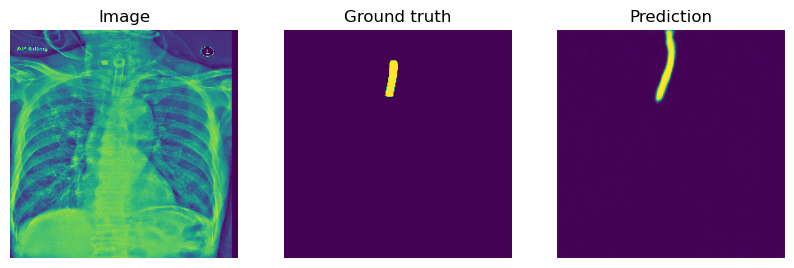

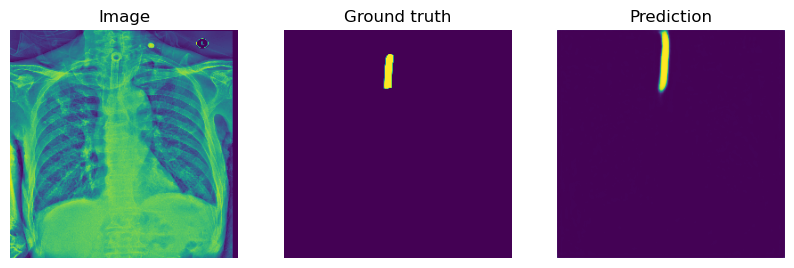

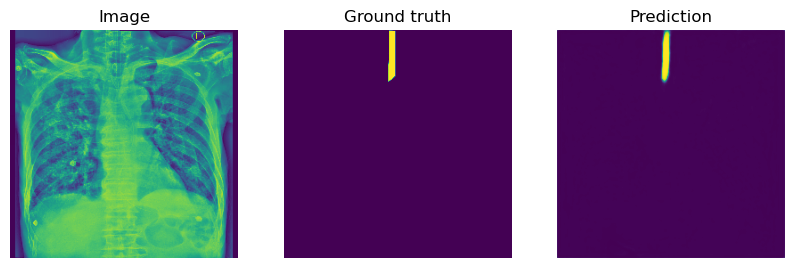

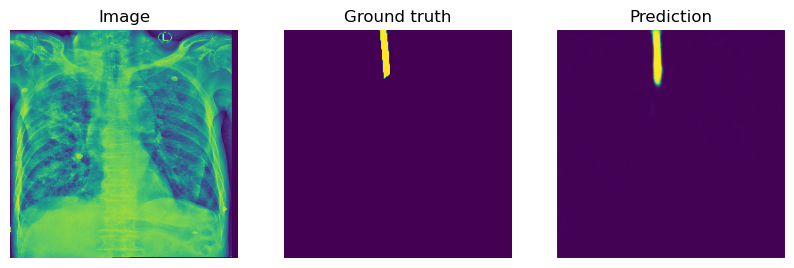

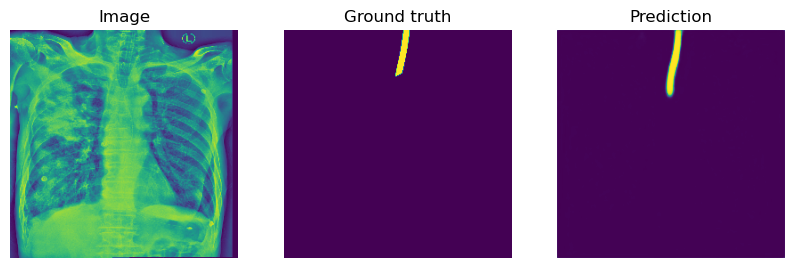

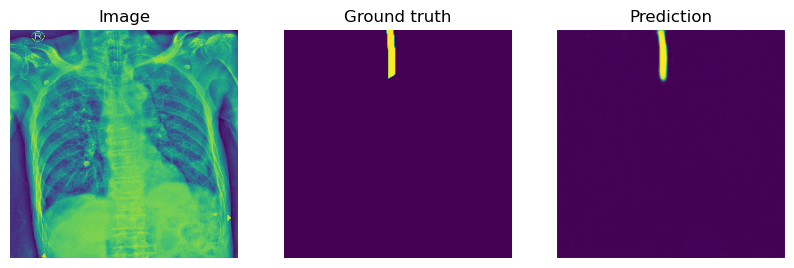

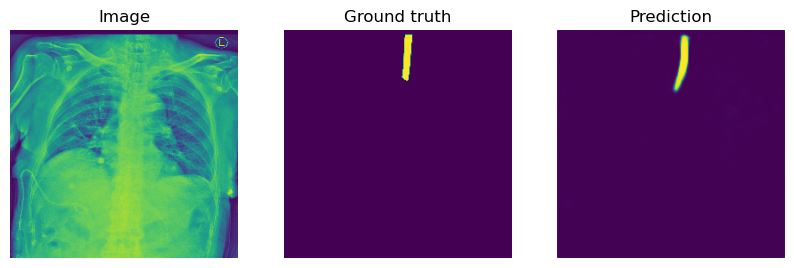

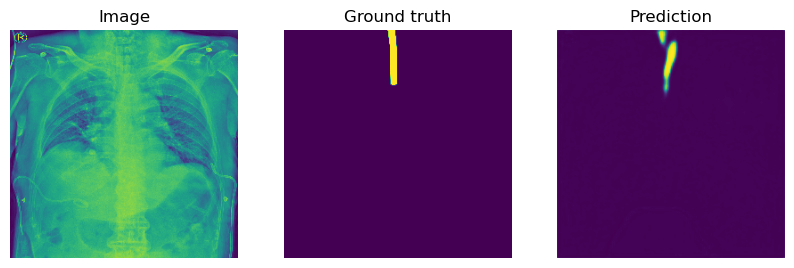

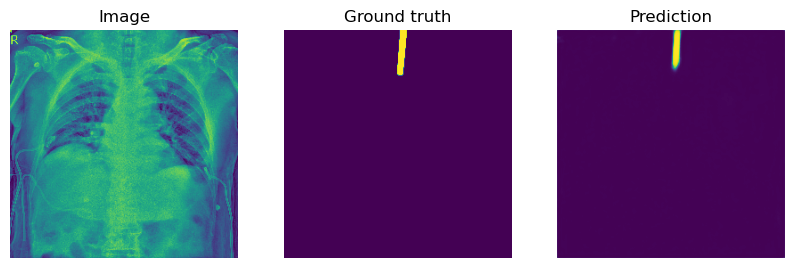

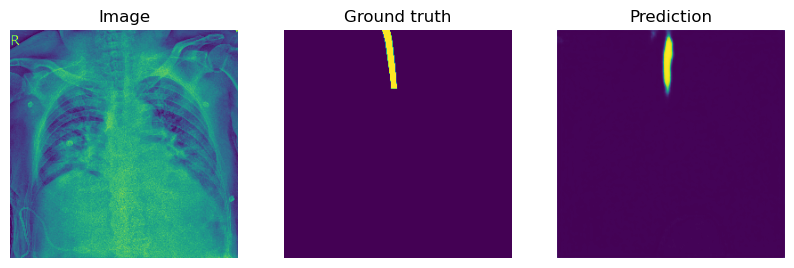

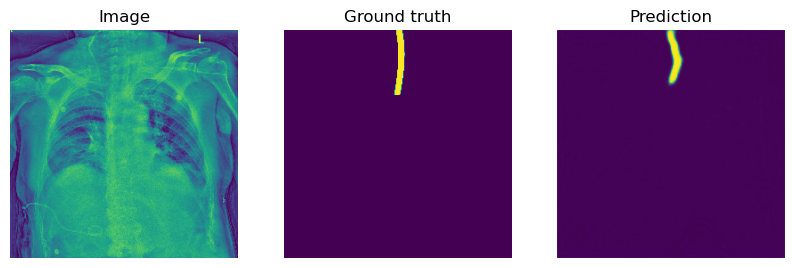

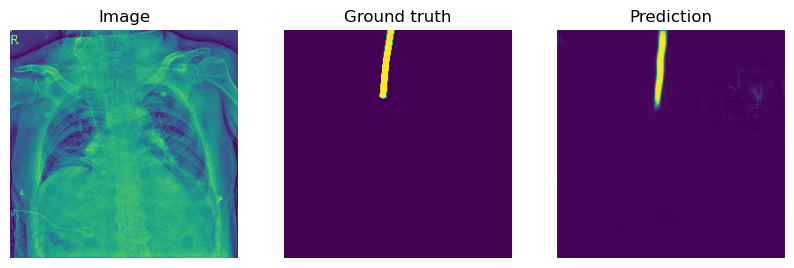

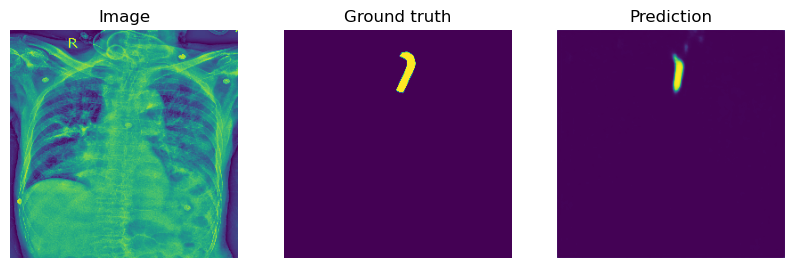

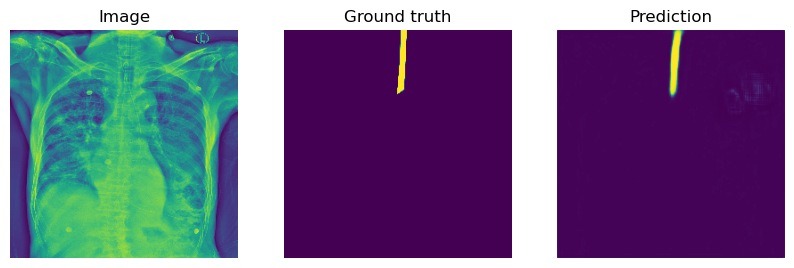

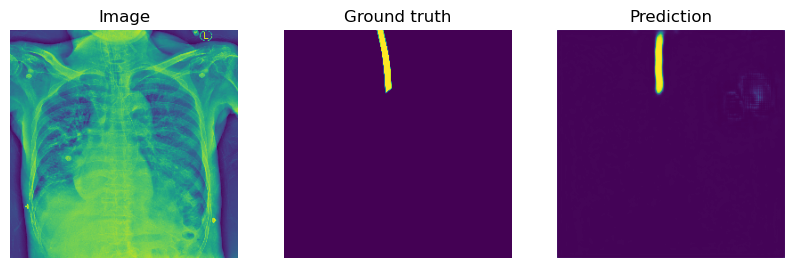

In [34]:
import torch
import matplotlib.pyplot as plt # 確保有這行
from itertools import islice # 確保有這行
# 可能還需要 numpy，如果前面的程式碼沒有匯入的話
import numpy as np
from itertools import islice
# 指定要顯示的批次索引
batch_index = 1

# 使用迭代器來訪問指定的批次
batch = next(islice(test_loader, batch_index, batch_index + 1))

# batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0])  # 使用整數索引訪問圖像
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze())  # just squeeze classes dim
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze())  # just squeeze classes dim
    plt.title("Prediction")
    plt.axis("off")

    plt.show()
